In [20]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
# import pandas_profiling
# from dataprep.eda import plot, plot_correlation, create_report, plot_missing
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

# Функции

In [21]:
'''Функция, возвращающая порядковый день в году'''

def get_days_count(x):  
    day = ((x.month-1) * 30)+x.day
    return day

'''Функция, возвращающая количество дней между датой заявки и сегодняшним числом'''

def get_days_beetwen(x):
    curr_date = datetime.today()
    count = (curr_date-x).days
    return count
    

'''Функция, возвращающая флаг подачи заявки в выходной день'''

def if_weekend(x):
    if x.weekday() in [5,6]:
        return 1
    else:
        return 0
    

# Загрузка данных

In [22]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

print(f'Размерность тренировочного датасета: {train.shape}')
print(f'Размерность тестового датасета: {test.shape}')

Размерность тренировочного датасета: (73799, 19)
Размерность тестового датасета: (36349, 18)


In [23]:
train[:4]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0


In [24]:
test[:4]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N


In [25]:
sub[:4]

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501


### Проверим, пересекаются ли данные в тренировочном и тестовом датасетах


In [26]:
set(test.client_id) & set(set(train.client_id))

set()

##### (Не пересекаются)

### Объединяем таблицы с добавлением параметра-указателя принадлежности к тестовой выборке

In [27]:
train['test'] = 0
test['test'] = 1
df = pd.concat([train, test], axis=0)

client_id            0.000000
app_date             0.000000
education            0.433962
sex                  0.000000
age                  0.000000
car                  0.000000
car_type             0.000000
decline_app_cnt      0.000000
good_work            0.000000
score_bki            0.000000
bki_request_cnt      0.000000
region_rating        0.000000
home_address         0.000000
work_address         0.000000
income               0.000000
sna                  0.000000
first_time           0.000000
foreign_passport     0.000000
default             33.000145
test                 0.000000
dtype: float64


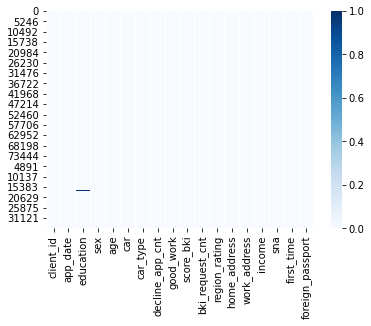

In [28]:
sns.heatmap(df.drop(['default','test'],axis=1).isnull(), cmap='Blues')
print(df.isna().mean() * 100) # ВЫражаем пропуски в процентах

Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту


####  Вывод: в тренировочной выборке   73799 записей, в тестовой 36349 записей. Имется небольшое количество пропусков в признаке education (0.43% суммарно), которые мы заполним. Данные в тренировочной и тестовой выборках не пересекаются 

In [29]:
# pandas_profiling.ProfileReport(df.drop(['client_id','default','test'],axis=1))

In [30]:
df[:3]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,0


In [31]:
edu_name = df['education'].value_counts().index.to_list() # Получаем список значений
edu_distr = df['education'].value_counts(normalize=True).values # Получаем список вероятностей
missing = df['education'].isnull() # Флаги с наличием пропусков
df.loc[missing, ['education']] = np.random.choice(
    edu_name, size=len(df[missing]), p=edu_distr) # Подставляем значения из списка имен в соответствии в вероятностью встречи имени

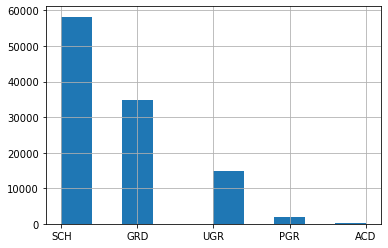

In [32]:
df['education'].hist()

## 1.Анализ данных

<function matplotlib.pyplot.show(*args, **kw)>

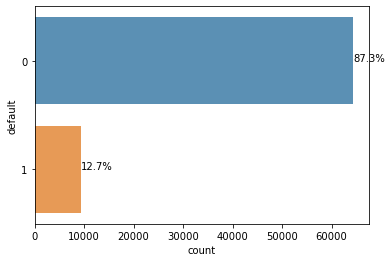

In [33]:
ax = sns.countplot(y='default', data= train, alpha=0.8)
total = train.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage,(x,y))
plt.show


## Имеется дисбаланс классов, попробуем его решить без применения методик по устранению дисбаланса и с ними


client_id        |110148     |int64 
app_date         |120        |object 
education        |5          |object 
sex              |2          |object 
age              |52         |int64 
car              |2          |object 
car_type         |2          |object 
decline_app_cnt  |24         |int64 
good_work        |2          |int64 
score_bki        |102618     |float64 
bki_request_cnt  |40         |int64 
region_rating    |7          |int64 
home_address     |3          |int64 
work_address     |3          |int64 
income           |1207       |int64 
sna              |4          |int64 
first_time       |4          |int64 
foreign_passport |2          |object 
default          |2          |float64 
test             |2          |int64 


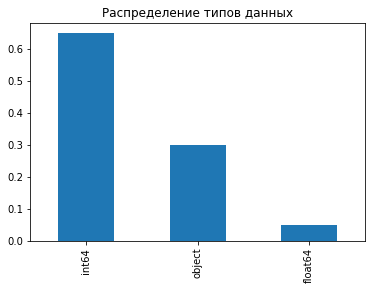

In [34]:
for i in df.columns:
    print('{0:<16} |{1:<10} |{2} '.format(i, df[i].nunique(), df[i].dtypes))
    train.dtypes.value_counts(normalize=True).plot(
        kind='bar', title='Распределение типов данных')

### Исходя из кол-ва возможных значений и описания признаков, делим признаки на числовые, категориальные и бинарные

In [35]:
bin_ = ['sex','car','car_type','foreign_passport','good_work']
num_ = ['age',  'income', 'score_bki']
cat_ = ['decline_app_cnt','bki_request_cnt','education','work_address','home_address', 'sna', 'region_rating','first_time']

## Не смотря на то, что признаки  'decline_app_cnt' и 'bki_request_cnt' похожи на числовые с выбросами, мы не будем избавляться от выбросов, но отметим эти признаки как категориальные, т.к. количество запросов в БКИ и количество отказов могут прояснить ситуацию с благополучностью и надежностью потенциального клиента.

# Посмотрим на них поближе



Распределение значений 'decline_app_cnt'

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
24        1
15        1
19        1
22        1
33        1
Name: decline_app_cnt, dtype: int64






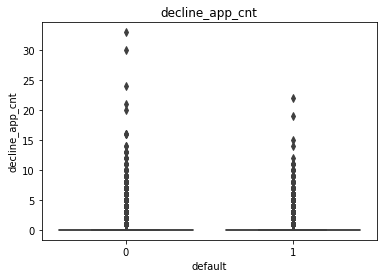



Распределение значений 'bki_request_cnt'

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
24        1
15        1
19        1
22        1
33        1
Name: decline_app_cnt, dtype: int64






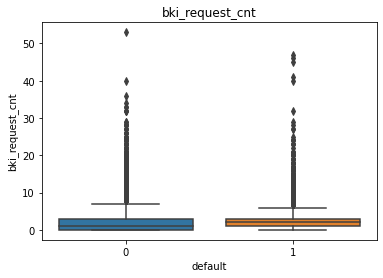

In [36]:
for i in ['decline_app_cnt','bki_request_cnt']:
    plt.figure()
    sns.boxplot(x=train['default'], y=df[i])
    print('\n\nРаспределение значений \'{0}\'\n\n{1}\n\n\n\n'.format(i,train["decline_app_cnt"].value_counts()))
    plt.title(i)
    plt.show()


# Числовые признаки

### Преобразуем признак с датой и добавим дополнительные фичи 

In [37]:
df['app_date'] = pd.to_datetime(df['app_date']) # Преобразуем в datetime
df['weekend'] = df['app_date'].apply(lambda x:(if_weekend(x))) # Флаг выходного дня
df['days_numb'] = df['app_date'].apply(lambda x:(get_days_count(x))) # Порядковый номер дня в году
df['days_beetwen'] = df['app_date'].apply(lambda x:(get_days_beetwen(x))) # Кол- во дней между подачей заявки и сегодняшним числом


In [38]:
df = df.drop('app_date',axis=1) # Удалим столбец app_date 

In [39]:
bin_ = bin_ + ['weekend']
num_ = num_ + ['days_numb','days_beetwen']


In [40]:
df

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,test,weekend,days_numb,days_beetwen
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,...,2,18000,4,1,N,0.0,0,1,31,2623
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,...,3,19000,4,1,N,0.0,0,0,72,2584
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,...,2,30000,1,4,Y,0.0,0,1,31,2623
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,...,3,10000,1,3,N,0.0,0,0,23,2632
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,...,3,30000,1,4,Y,0.0,0,0,108,2547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,83775,SCH,F,37,N,N,1,0,-1.744976,3,...,3,15000,4,1,N,NaN,1,0,91,2565
36345,106254,GRD,F,64,Y,Y,0,0,-2.293781,3,...,2,200000,1,4,N,NaN,1,0,115,2540
36346,81852,GRD,M,31,N,N,2,0,-0.940752,1,...,2,60000,4,2,N,NaN,1,1,90,2566
36347,1971,UGR,F,27,N,N,1,0,-1.242392,2,...,3,30000,1,1,N,NaN,1,0,7,2648


In [41]:
train

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,0


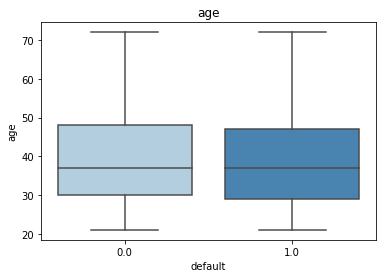

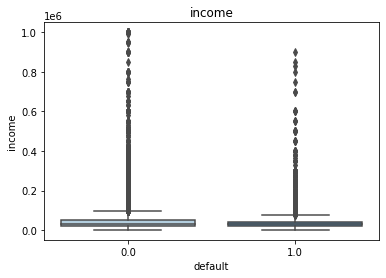

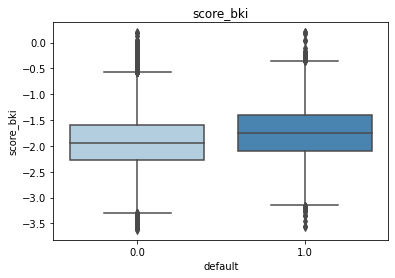

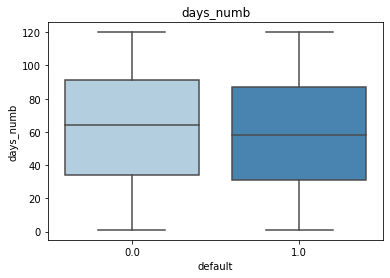

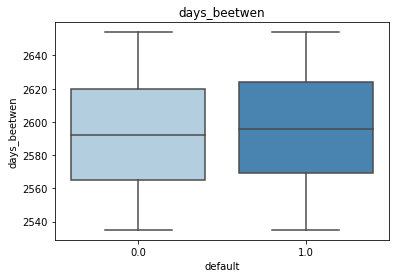

In [42]:
for i in num_:
    plt.figure()
    sns.boxplot(x=df['default'][df['test']==0], y=df[i],palette='Blues')
    plt.title(i)
    plt.show()


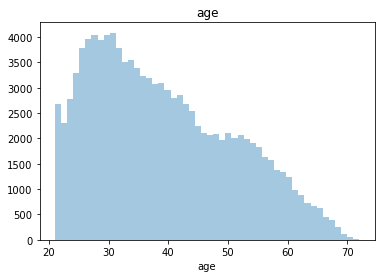

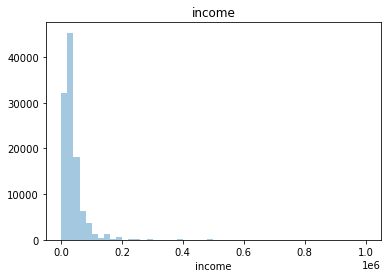

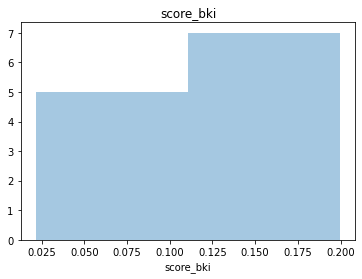

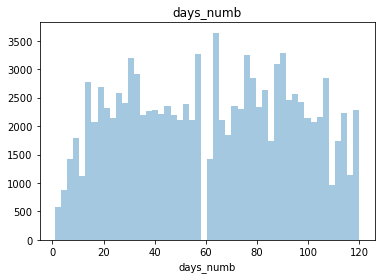

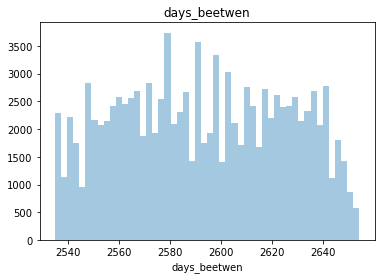

In [43]:
# Построим распределенеие числовых признаков

for i in num_:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

In [44]:
def get_blowout(x):
    blowouts = dict.fromkeys(['age', 'income', 'score_bki', 'days_numb', 'days_beetwen'])
    for i in num_:
        Q1 = np.percentile(df[i],25)
        Q3 = np.percentile(df[i],75)
        q_range = Q3 - Q1        
        right = (df[i][df[i] > (Q3+1.5*q_range)]).values
        left = (df[i][df[i] < (Q1-1.5*q_range)]).values
        blowouts.update({i:(set(left),set(right))})
    return display(blowouts)





   

In [45]:
df

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,test,weekend,days_numb,days_beetwen
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,...,2,18000,4,1,N,0.0,0,1,31,2623
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,...,3,19000,4,1,N,0.0,0,0,72,2584
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,...,2,30000,1,4,Y,0.0,0,1,31,2623
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,...,3,10000,1,3,N,0.0,0,0,23,2632
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,...,3,30000,1,4,Y,0.0,0,0,108,2547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,83775,SCH,F,37,N,N,1,0,-1.744976,3,...,3,15000,4,1,N,NaN,1,0,91,2565
36345,106254,GRD,F,64,Y,Y,0,0,-2.293781,3,...,2,200000,1,4,N,NaN,1,0,115,2540
36346,81852,GRD,M,31,N,N,2,0,-0.940752,1,...,2,60000,4,2,N,NaN,1,1,90,2566
36347,1971,UGR,F,27,N,N,1,0,-1.242392,2,...,3,30000,1,1,N,NaN,1,0,7,2648


In [46]:
df[num_]

,age,income,score_bki,days_numb,days_beetwen
0,62,18000,-2.008753,31,2623
1,59,19000,-1.532276,72,2584
2,25,30000,-1.408142,31,2623
3,53,10000,-2.057471,23,2632
4,48,30000,-1.244723,108,2547
...,...,...,...,...,...
36344,37,15000,-1.744976,91,2565
36345,64,200000,-2.293781,115,2540
36346,31,60000,-0.940752,90,2566
36347,27,30000,-1.242392,7,2648


### Видим, что на графиках имеется выраженный хвост вправо. Прологарифмируем.

In [47]:
df['score_bki'] = df['score_bki'] + 99 # Прибавили число, чтобы избавитья от inf значений 
for col in num_:
    df[col] = np.log(df[col])

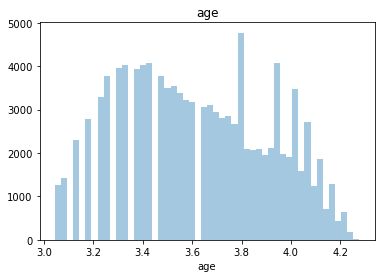

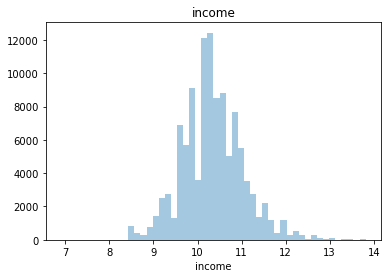

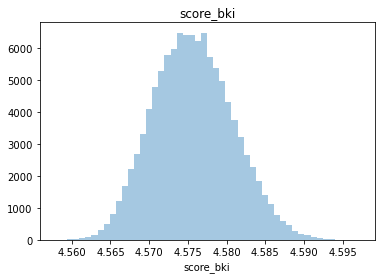

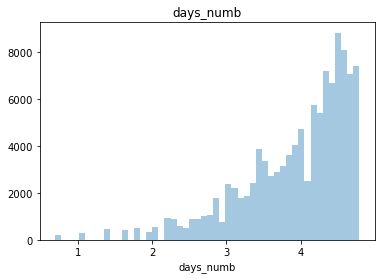

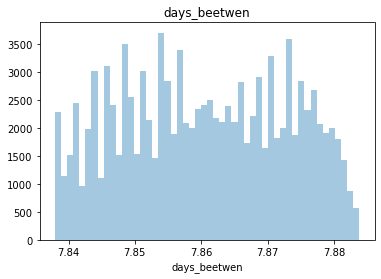

In [48]:
for i in num_:
    plt.figure()
    sns.distplot(df[i][
        df[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

,age,income,score_bki,days_numb,days_beetwen
age,1.000000,0.090011,0.109346,0.019506,0.017699
income,0.090011,1.000000,0.002454,0.004565,0.002563
score_bki,0.109346,0.002454,1.000000,0.052822,0.062049
days_numb,0.019506,0.004565,0.052822,1.000000,0.926987
days_beetwen,0.017699,0.002563,0.062049,0.926987,1.000000


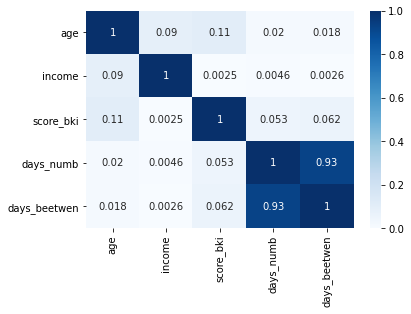

In [49]:
sns.heatmap(df[num_].corr().abs(), vmin=0, vmax=1,cmap='Blues',annot=True)
display(df[num_].corr().abs())

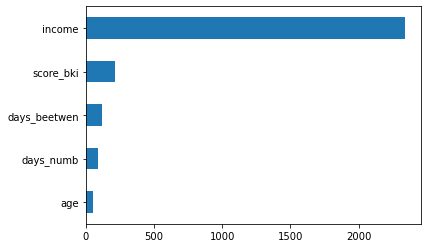

In [50]:
df_num = df.drop(bin_+cat_, axis=1).drop(['client_id'], axis=1)

imp_num = Series(f_classif(df_num[df_num['test'] == 0].drop(
    ['default', 'test'], axis=1), df_num['default'][df_num['test'] == 0])[0], index=num_)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

### Большую значимость имеет признак income

### По корреляционной матрице видим высокую корреляцию между новыми признаками  days_beetwen и days_numb. Удалим days_beetwen

In [51]:
df = df.drop('days_beetwen',axis = 1 )
num_.remove('days_beetwen')

#  Бинарные признаки

### Строим графики категориальных и бинарных признаков от значения 'default' 

In [52]:
df[df['test']==0]

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address,work_address,income,sna,first_time,foreign_passport,default,test,weekend,days_numb
0,25905,SCH,M,4.127134,Y,Y,0,0,4.574621,1,...,1,2,9.798127,4,1,N,0.0,0,1,3.433987
1,63161,SCH,F,4.077537,N,N,0,0,4.579521,3,...,2,3,9.852194,4,1,N,0.0,0,0,4.276666
2,25887,SCH,M,3.218876,Y,N,2,0,4.580794,1,...,1,2,10.308953,1,4,Y,0.0,0,1,3.433987
3,16222,SCH,F,3.970292,N,N,0,0,4.574118,2,...,2,3,9.210340,1,3,N,0.0,0,0,3.135494
4,101655,GRD,M,3.871201,N,N,0,1,4.582467,1,...,2,3,10.308953,1,4,Y,0.0,0,0,4.682131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,GRD,F,3.806662,N,N,0,0,4.576852,3,...,1,2,9.740969,4,4,N,0.0,0,0,4.158883
73795,76821,SCH,M,3.713572,Y,Y,0,0,4.574113,1,...,2,2,11.156251,1,4,N,0.0,0,0,4.430817
73796,103695,SCH,M,3.433987,N,N,0,0,4.579723,4,...,2,3,10.714418,2,2,N,0.0,0,0,4.718499
73797,861,SCH,F,3.367296,N,N,0,1,4.580064,3,...,1,3,9.472705,2,3,N,1.0,0,1,1.386294


In [53]:
# sns.barplot(x='sex', y='proportion',hue='default' ,  data=df[df['test']==0][['sex','default']].value_counts(normalize=True).rename('proportion').reset_index())

In [58]:
df[df['test'] == 0][[k, 'default']].value_counts(normalize=True)

AttributeError: 'DataFrame' object has no attribute 'value_counts'

AttributeError: 'DataFrame' object has no attribute 'value_counts'

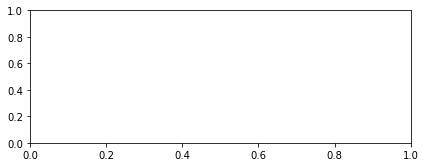

In [55]:
plt.figure(figsize=[15, 20])
i = 1

y, hue = 'proportion', 'default'

for k in bin_:
    plt.subplot(7, 2, i)
    sns.barplot(x=k, y='proportion', hue='default',  data=df[df['test'] == 0][[
                k, 'default']].value_counts(normalize=True).rename('proportion').reset_index())
    plt.title('Categorical Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()    
    

    

In [ ]:
# sns.barplot(y=train.home_address.value_counts(normalize=True).index, x="default",  data=train.home_address.value_counts(normalize=True))

In [ ]:
# sns.barplot(x=train['default'],y=train['age'].value_counts())

In [ ]:
train.home_address.value_counts(normalize=True)

In [ ]:
df_cat


In [ ]:
df_cat

In [ ]:
label_encoder = LabelEncoder()

for column in bin_:
    df_bin[column] = label_encoder.fit_transform(df_bin[bin_][column])

# убедимся в преобразовании
df_bin[bin_].head()

In [ ]:
df_cat['education'] = label_encoder.fit_transform(df_cat['education'])

In [ ]:
df_cat = df.drop(num_+bin_, axis=1).drop(['client_id', 'app_date', ], axis=1)


imp_cat = Series(mutual_info_classif(df_cat[df_cat['test'] == 0].drop(['test', 'default'], axis=1), df_cat['default'][df['test'] == 0],
                                     discrete_features=True), index=cat_)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [ ]:
df_bin = df.drop(num_+cat_, axis=1).drop(['client_id', 'app_date', ], axis=1)

imp_bin = Series(mutual_info_classif(df_bin[df_bin['test'] == 0].drop(['test', 'default'], axis=1), df_bin['default'][df['test'] == 0],
                                     discrete_features=True), index=bin_)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

In [ ]:
# X_num_train = RobustScaler().fit_transform(
#     df_num[df_num['test'] == 0].drop(['test', 'default'], axis=1).values)
# X_cat_train = OneHotEncoder(sparse=False).fit_transform(
#     df_cat[df_cat['test'] == 0].drop(['test', 'default'], axis=1).values)
# X_bin_train = OneHotEncoder(sparse=False).fit_transform(
#     df_bin[df_bin['test'] == 0].drop(['test', 'default'], axis=1).values)
# X_num_test = RobustScaler().transform(
#     df_num[df_num['test'] == 1].drop(['test', 'default'], axis=1).values)
# X_cat_test = OneHotEncoder(sparse=False).fit(
#     df_cat[df_cat['test'] == 1].drop(['test', 'default'], axis=1).values)
# X_bin_test = OneHotEncoder(sparse=False).fit(
#     df_bin[df_bin['test'] == 1].drop(['test', 'default'], axis=1).values)

In [ ]:
scaler_num = RobustScaler()

X_num_train = scaler.fit_transform(
    df_num[df_num['test'] == 0].drop(['test', 'default'], axis=1).values)
X_num_test = scaler.transform(
    df_num[df_num['test'] == 1].drop(['test', 'default'], axis=1).values)

X_cat_train = OneHotEncoder(sparse=False).fit_transform(df_cat[cat_][df['test'] == 0])
X_cat_test = OneHotEncoder(sparse=False).fit_transform(df_cat[cat_][df['test'] == 1])

X_bin_train = df_bin[bin_][df['test']==0]
X_bin_test = df_bin[bin_][df['test']==1]

In [ ]:
df

In [ ]:
# X_bin_train.shape

In [ ]:
X = np.hstack([X_num_train, X_cat_train, X_bin_train])
y = df['default'][df['test'] == 0].values
# X_test = np.hstack([X_num_test, X_cat_test, X_bin_test])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=50)

In [ ]:
y_test.shape

In [ ]:
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba = y_pred_proba[:,1]
y_pred = model.predict(X_test)
# model.fit(X, y)
# y_pred_proba = model.predict_proba(X_sub)
# y_pred = model.predict(X_sub)

In [ ]:
y_pred_proba

In [ ]:
y_train.shape

In [ ]:
f1_score(y_pred,y_test)

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
id_test = df['client_id'][df['test']==1]

In [ ]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': y_pred_proba})
my_submission.to_csv('submission.csv', index=False)

In [ ]:
my_submission